## Load packages

In [1]:
using Revise
using SourceSeparationNF
using LinearAlgebra, Random
using BenchmarkTools, ProfileView
using PyPlot

BLAS.set_num_threads(1)

## Load data

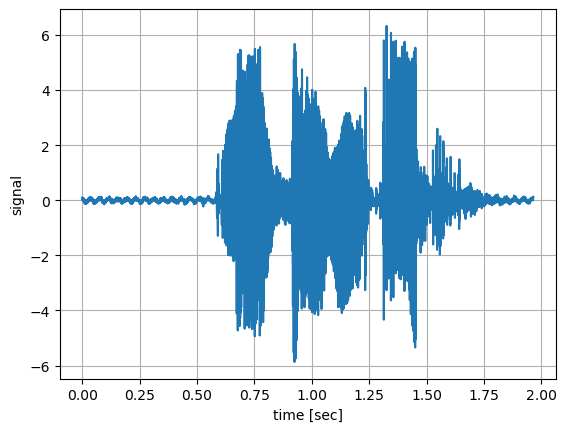

┌ Info: data already processed.
└ @ SourceSeparationNF d:\OneDrive - TU Eindhoven\phd\Projects\SourceSeparationNF\src\data.jl:72
┌ Info: data already processed.
└ @ SourceSeparationNF d:\OneDrive - TU Eindhoven\phd\Projects\SourceSeparationNF\src\data.jl:72
┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\s151781\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


In [2]:
data_train = prepare_data("../data/train/raw", "../data/train/processed"; fs=16000)
data_test = prepare_data("../data/test/raw", "../data/test/processed"; fs=16000)

plt.plot(collect(1:length(data_train[1]))./16000, data_train[1])
plt.grid()
plt.xlabel("time [sec]")
plt.ylabel("signal");

## Create model

In [3]:
function create_neural_network(dim; optimizer::Type{<:AbstractOptimizer}=Adam, batch_size::Int=128)

    return Model(dim,
        (
            DenseLayer(dim, 4; optimizer=optimizer, batch_size=batch_size),
            ReluLayer(4; batch_size=batch_size),
            DenseLayer(4, 4; optimizer=optimizer, batch_size=batch_size),
            ReluLayer(4; batch_size=batch_size),
            DenseLayer(4, dim; optimizer=optimizer, batch_size=batch_size)
        )
    )

end

create_neural_network (generic function with 1 method)

In [4]:
batch_size = 128

model = Model(
    16,
    (
        MvAdditiveLayer(16, create_neural_network(8; batch_size=batch_size); batch_size=batch_size),
        PermutationLayer(16; batch_size=batch_size),
        MvAdditiveLayer(16, create_neural_network(8; batch_size=batch_size); batch_size=batch_size),
        PermutationLayer(16; batch_size=batch_size),
        MvAdditiveLayer(16, create_neural_network(8; batch_size=batch_size); batch_size=batch_size),
        PermutationLayer(16; batch_size=batch_size),
        MvAdditiveLayer(16, create_neural_network(8; batch_size=batch_size); batch_size=batch_size),
    )
);

In [5]:
isinvertible(model), nr_params(model)

(true, 384)

In [8]:
setlr!(model, 1e-5)
loss_function = MSE(batch_size=128)
;

## Show timings

In [ ]:
# @benchmark forward!($(model), $(randn(16,128)))

In [ ]:
# @benchmark propagate_error!($(model), $(randn(16,128)))

In [ ]:
# @benchmark update!($model)

In [ ]:
# @benchmark SourceSeparationNF.train_batch!($model, $input, $output, $loss_function)

## Perform training

In [9]:
train_suite = TrainSuite(
    model,                  # model
    loss_function,          # loss function
    data_train,             # train data
    data_test,              # test data
    2,                      # number of epochs
    "../logs/"              # path to log directory
);

In [11]:
run!(train_suite)

epoch 002: 100%|████████████████████████████████████████| Time: 0:14:33
  mse_train:  1.1352345010733873
  mse_test:   1.1987159572912973


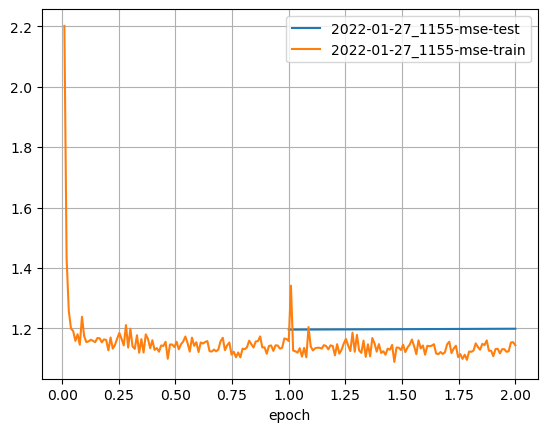

In [12]:
plot_logs(; path="../logs/");